In [1]:
!git clone https://github.com/Marlup/Simulation-of-investment-and-compound-returns.git

Cloning into 'Simulation-of-investment-and-compound-returns'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 116 (delta 54), reused 42 (delta 15), pack-reused 0
Receiving objects: 100% (116/116), 571.19 KiB | 4.43 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [2]:
import os
os.chdir("./Simulation-of-investment-and-compound-returns")
CURRENCY = "€"

In [3]:
# data processing
import numpy as np
import pandas as pd
# pyplot
from matplotlib import pyplot as plt
# seaborn
import seaborn as sns
# bokeh
from bokeh import plotting as bk
from bokeh.models import Span
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

# Compound utils
from compound import (
    get_compound_return,
    simulate_compound_return,
    build_dataframe,
    MONTHS_IN_YEAR,
    DEFAULT_RETIREMENT_YEARS,
    define_scenario,
    plot_scenario_bokeh
)

In [4]:
# Plot earning and contribution evolutions
def plot_scenario_bokeh(earnings, balances, principal, w= 400, h=300):
    plot_e = bk.figure(width=w,
                       height=h,
                       title='Evolution of yields',
                       #tools='hover'
                       )

    ## Earning plot

    source_e = ColumnDataSource(
        data=dict(month=np.arange(len(earnings)),
                  year=np.arange(len(earnings)) // 12,
                  earning=earnings
                  )

        )

    curve_e = plot_e.line(x='month',
                          y='earning',
                          source=source_e)

    # zero-earnings baseline
    hline_e = Span(location=earnings[0],
                   dimension='width',
                   line_color='red',
                   line_width=1,
                   line_dash='dashed')
    plot_e.add_layout(hline_e)

    #plot.renderers.extend([curve, hline])

    # Annotations
    plot_e.xaxis.axis_label = "month"
    plot_e.yaxis.axis_label = "yield (€)"

        # hover tools for earning curve
    hover_e = HoverTool(
        tooltips=[
            ('year',  '@year (month @month)'),
            ('yield', '€ @earning{%0.2f}'), # use @{ } for field names with spaces
        ],

        formatters={
            '@month': 'printf', # use default 'numeral' formatter for other fields
            '@earning': 'printf',   # use 'printf' formatter for '@{adj close}' field
        },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline'
    )
    plot_e.add_tools(hover_e)

    ## Balance plot

    plot_b = bk.figure(width=w,
                       height=h,
                       title='Evolution of yields',
                       #tools='hover'
                      )

    source_b = ColumnDataSource(
        data=dict(month=np.arange(len(balances)),
                  year=np.arange(len(balances)) // 12,
                  balance=balances
                  )

        )
    curve_b = plot_b.line(x='month',
                        y='balance',
                        source=source_b)

    # zero-balance baseline
    hline_b = Span(location=earnings[0],
                   dimension='width',
                   line_color='red',
                   line_width=1,
                   line_dash='dashed')
    plot_b.add_layout(hline_b)

    # hover tools for balance curve
    hover_b = HoverTool(
        tooltips=[
            ('year',  '@year (month @month)'),
            ('balance', '€ @balance{%0.2f}'), # use @{ } for field names with spaces
        ],

        formatters={
            '@month': 'printf', # use default 'numeral' formatter for other fields
            '@balance': 'printf',   # use 'printf' formatter for '@{adj close}' field
        },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline'
    )
    plot_b.add_tools(hover_b)

    return plot_e, plot_b

In [5]:
sns.set_style('darkgrid')
sns.color_palette("Paired")
sns.set_palette("Paired")

### Calculation of composed return. Composed return function

In [6]:
# Calculation of composed return. Composed return function
principal_amount = 10_000
annual_contribution = 200 * 12
roi = 0.075
years = 30
compounding_frequency = 12

periodic_contribution = annual_contribution / compounding_frequency

amount, accum_roi = get_compound_return(
    principal_amount,
    roi,
    compounding_frequency,
    periodic_contribution,
    years,
    True
    )
print(f"Total amount {amount}")
print(f"Accumulated roi {accum_roi}")

Total amount 116672.76
Accumulated roi 9.42


### Estimation of composed return. Simulation

Scenario

In [9]:
# @title Investing parameters for yields scenario

# Define initial parameters
initial_principal = 10000 # @param {type:"number", "min": 0.0, "max": 1.0e9}
monthly_contribution = 200 # @param {type:"number", "min": 0.0, "max": 1.0e9}
annual_contribution = monthly_contribution * 12
annual_roi = 0.06 # @param {type:"number", "min": 0.0, "max": 1.0}
duration = 60 # @param {type:"slider", "min": 0.0, "max": 150, "step": 1}
retirement_at = 30 # @param {type:"slider", "min": 0, "max": 150, "step": 1}
retirement_income = 1000 # @param {type:"number", "min": 0.0, "max": 1.0e9}
retirement_contribution_ratio = 0.1# @param {type:"number", "min": 0.001, "max": 1.0}
retirement_contribution = retirement_contribution_ratio * annual_contribution
inflation_rate = 0.04
tax_rate = 0.25
 # Compounding once per year
compounding_frequency = 12 # @param {type:"slider", "min": 0, "max": 24, "step": 1}

# Calculate the total balance and earnings using the updated function
total_balance, earnings, balances = simulate_compound_return(
    principal=initial_principal,
    annual_roi=annual_roi,
    compounding_frequency=compounding_frequency,
    annual_contribution=annual_contribution,
    investment_duration=duration,
    retirement_at=retirement_at,
    retirement_income=retirement_income,
    retirement_contribution=retirement_contribution,
    inflation_rate=inflation_rate,
    tax_rate=tax_rate,
    return_time_yields=True
)

# Calculate total earnings, total input contribution, and earnings per contribution
total_earnings = sum(earnings)

# Print the results
print(f"Total balance after {duration} years:", round(total_balance, 2))
print("Total earnings:", round(total_earnings, 2))

# Basic plot setup
renderer_e, renderer_b = plot_scenario_bokeh(earnings,
                               balances,
                               initial_principal)

_ , _= bk.show(renderer_e), bk.show(renderer_b)

Total balance after 60 years: -169772.4
Total earnings: 106783.9


In [ ]:
step_amount = 5_000
max_amount = 20_000
initial_amounts = np.arange(step_amount,
                            max_amount + step_amount,
                            step_amount)
virtual_returns = np.arange(0.06, 0.11, 0.01)
years_of_investment = [31, 40, 50, 60]#np.arange(30, 30 + 5, 5)
inflation_rates = [0.0, 0.02, 0.03, 0.04, 0.05, 0.06]#np.arange(30, 30 + 5, 5)
retirement_years = 30
retir_incomes = [
    1.0e3,
    1.5e3,
    2.0e3,
    2.5e3,
    3.0e3
    ]
terms = (1, 3, 6, 12)
yearly_contributions = list(map(lambda x: 12 * x, range(50, 500, 50) ))
results = define_scenario(initial_amounts,
                          virtual_returns,
                          years_of_investment,
                          terms,
                          yearly_contributions,
                          inflation_rates,
                          retirement_years,
                          retir_incomes
                          )
df = build_dataframe(results)
df

,initial_amount,roi,duration,term,contribution,inflation_rate,retirement_income,retirement_contribution,total_amount
0,5000,0.06,31,1,600,0.00,1000.0,300.0,73601.364620
1,5000,0.06,31,1,600,0.00,1500.0,300.0,67433.583434
2,5000,0.06,31,1,600,0.00,2000.0,300.0,61265.802247
3,5000,0.06,31,1,600,0.00,2500.0,300.0,55098.021061
4,5000,0.06,31,1,600,0.00,3000.0,300.0,48930.239874
...,...,...,...,...,...,...,...,...,...
86395,20000,0.10,60,12,5400,0.06,1000.0,2700.0,730722.928186
86396,20000,0.10,60,12,5400,0.06,1500.0,2700.0,396981.152625
86397,20000,0.10,60,12,5400,0.06,2000.0,2700.0,63239.377064
86398,20000,0.10,60,12,5400,0.06,2500.0,2700.0,-169300.358569


In [ ]:
# Example case
initial_amounts = (10_000, 15_000)
max_roi = 0.09
max_term = 12
contributions = (1200, 2400)
min_years = 60
retirement_incomes = (1000, 2000)
inflation_rates = (0.04, 0.06)

df_positive = df[df["total_amount"] > 0.0]
# Round up 'total_amount'
df_positive["total_amount"] = df_positive["total_amount"].round(1)
print('Cases with positive amount:', df_positive.shape)

# Filter by example case
df_case = df_positive[(df_positive["initial_amount"].between(initial_amounts[0], initial_amounts[1])) & \
                      (df_positive["roi"] <= max_roi) & \
                      (df_positive["term"] <= max_term) & \
                      (df_positive["contribution"].between(contributions[0], contributions[1])) & \
                      (df_positive["duration"] >= min_years) & \
                      (df_positive["retirement_income"].between(retirement_incomes[0], retirement_incomes[1])) & \
                      ((df_positive["inflation_rate"].between(inflation_rates[0], inflation_rates[1])))
                      ].sort_values(["roi", "term", "total_amount", "retirement_income", "contribution"],
                                    ascending=[True, True, False, False, False])
df_case

Cases with positive amount: (53441, 9)


<ipython-input-47-d7e409f15ee2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive["total_amount"] = df_positive["total_amount"].round(1)


,initial_amount,roi,duration,term,contribution,inflation_rate,retirement_income,retirement_contribution,total_amount
55185,15000,0.08,60,1,2400,0.04,1000.0,1200.0,84568.3
33585,10000,0.08,60,1,2400,0.04,1000.0,1200.0,27726.9
55455,15000,0.08,60,3,2400,0.04,1000.0,1200.0,72322.2
33855,10000,0.08,60,3,2400,0.04,1000.0,1200.0,17240.0
55725,15000,0.08,60,6,2400,0.04,1000.0,1200.0,54906.2
34125,10000,0.08,60,6,2400,0.04,1000.0,1200.0,2308.1
55995,15000,0.08,60,12,2400,0.04,1000.0,1200.0,23171.3
59505,15000,0.09,60,1,2400,0.04,1000.0,1200.0,399054.3
37905,10000,0.09,60,1,2400,0.04,1000.0,1200.0,295918.5
59475,15000,0.09,60,1,1800,0.04,1000.0,900.0,170821.9


Case:
- €10,000 initial amount
- 30 years investment duration
- 12 months term
- €200 monthly contribution
- retirement income €1000
- 0.04 inflation rate

Number of cases: 5


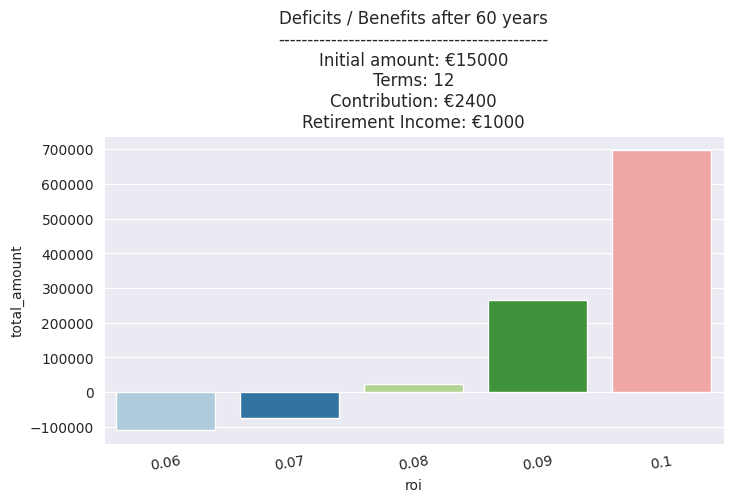

In [ ]:
case_ini_amount = 15_000
case_years = 60
case_terms = 12
case_monthly_contribution = 200
case_annual_contribution = case_monthly_contribution * MONTHS_IN_YEAR
retir_income = 1000
inflation = 0.04
case_rois = df[(df["initial_amount"] == case_ini_amount) & \
                (df["duration"] == case_years) & \
                (df["term"] == case_terms) & \
                (df["contribution"] == case_annual_contribution) & \
                (df["retirement_income"] == retir_income) & \
                (df["inflation_rate"] == inflation)
                ][["roi", "total_amount"]].round(2)

print(f"Number of cases: {case_rois.shape[0]}")

plt.figure(figsize=(8, 4))
_ = sns.barplot(data=case_rois,
                x="roi",
                y="total_amount",
               )

title = f"Initial amount: {CURRENCY}{case_ini_amount}\nTerms: {case_terms}\nContribution: {CURRENCY}{case_annual_contribution}\nRetirement Income: {CURRENCY}{retir_income}"
_ = plt.title(f"Deficits / Benefits after {case_years} years\n----------------------------------------------\n"+ title)
_ = plt.xticks(rotation=10)